# Neural Networks in PyTorch
## Chapter 9: Binary Classification of Images: Single-Layer Perceptron versus Convolutional Neural Network
Yen Lee Loh, 2022-12-11

This demo does a comparison of SLP and CNN for binary classification.  It shows that CNNs perform extremely well.

---
## 1. Set up and load the MNIST Digits dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn        # import torch.nn as nn
import torchvision.datasets # In functional.py: patch PILLOW_VERSION--> __version__
import torchvision.transforms
#import time
from collections.abc import Iterable
rng = np.random.default_rng()
np.set_printoptions (linewidth=300)
#plt.rcParams.update ({'font.family':'monospace', 'font.size':11})
plt.rcParams.update ({'font.family':'serif', 'font.size':13})


def gallery(xnij, cmap='viridis', labels=None, size=1):  # size is in inches
  '''
  gallery(xnij)
  
      Display an array of grayscale images.
  '''
  nmax = len(xnij)
  cols = min(20,nmax) ; rows = (nmax+cols-1)//cols
  wspace = 0.02 ; hspace = 0.02
  if isinstance (labels, Iterable) or labels!=None:   # if user has supplied labels
    hspace = .35
    
  fig,axs = plt.subplots (rows,cols, figsize=(cols*size*(1+wspace),rows*size*(1+hspace)), gridspec_kw={'wspace':wspace,'hspace':hspace})
  if nmax==1: axs = np.array([[axs]])
  axs = axs.flatten()
  for ax in axs:
      ax.axis ('off')
  for n in range(nmax):
      ax = axs[n]
      if isinstance (cmap, Iterable) and not isinstance (cmap, str):
        c = cmap[n]
      else:
        c = cmap
      ax.imshow (xnij[n], cmap=c)
      ax.set_aspect('equal')
      if isinstance (labels, Iterable):
        ax.set_title (str(labels[n]))

def metrics (Yn, yn):
  '''
  totalExamples,misclassifiedExamples,confusionMatrix = metrics (modelOutputs, trueOutputs)
  
      This function accepts a set of model outputs (predictions) and a set of training outputs (labels).
      It returns various integers.  It's easiest to understand this by seeing an example.
  '''
  nmax = len(yn)
  ymax = max(yn)+1
  confmat = np.zeros ([ymax, ymax], dtype=int)   # confmat[Y][y]
  for n in range(nmax): confmat[yn[n], Yn[n]] += 1
  ntot = np.sum(confmat)
  nerr = ntot - np.trace(confmat)
  return ntot,nerr,confmat

def select (inputs, outputs, classes, nT, nV, shuffle=False):
  '''
  xT,yT,xV,yV = select (MNISTinputs, MNISToutputs, [5,6,8], [100,100,100], [200,200,200])

      Given a set of inputs and outputs, 
      construct a training set consisting of the first 100 5's, 100 6's, 100 8's, 
      and a validation set consisting of the next 200 5's, 200 6's, and 200 8's.
      If the original set has fewer than 300 5's, 6's, or 7's, raise an exception.
  '''
  assert len(classes) == len(nT) and len(nT) == len(nV)
  allT = []
  allV = []
  for k in range(len(classes)):
    indices, = np.where(outputs==classes[k])
    ntot = len(indices)
    indices = rng.choice (indices, nT[k] + nV[k], False)    # randomly choose 300
    indicesT,indicesV = np.split (indices, [nT[k]])
    allT += indicesT.tolist()
    allV += indicesV.tolist()
    print ('For class {}, given {} examples, we chose {} for training and {} for validation. '.format(classes[k], ntot, len(indicesT), len(indicesV)))
  if shuffle:
    rng.shuffle (allT)
    rng.shuffle (allV)
  return inputs[allT], outputs[allT], inputs[allV], outputs[allV]



def train(xnd, ynd, model, lossFunc, epochs=10000, learningRate=0.01, lossTarget=0.0001, reportInterval=1000):
  '''
  train (xnd, ynd, model, lossFunc, epochs=10000, learningRate=0.01, lossTarget=0.0001, reportInterval=1000)

      xnd      a torch.Tensor representing N training inputs (which are D-vectors)
      ynd      a torch.Tensor representing N training outputs (usually 1-vectors)
      model    a nn.Module that accepts a set of inputs and returns a set of outputs
      lossFunc a 
      and a validation set consisting of the next 200 5's, 200 6's, and 200 8's.
      If the original set has fewer than 300 5's, 6's, or 7's, raise an exception.
  '''
  optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
  model.train()                  # put model in training mode
  for t in range(epochs):      # t is the epoch number
    Ynd = model(xnd)             # uppercase Y = model prediction
    loss = lossFunc(Ynd,ynd)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if t % reportInterval == 0 or t==epochs:
      F = loss.item()
      print('Training epoch {}/{}  \t Loss = {:.4f}'.format(t, epochs, F))
      if F < lossTarget:
        print('Training epoch {}/{}  \t Loss = {:.4f} < lossTarget\n'.format(t, epochs, F))
        return
  print ('Warning: loss > lossTarget!\n')

In [2]:
#================ DOWNLOAD THE MNIST-TRAIN DATASET, WHICH CONTAINS 60000 HANDWRITTEN DIGITS
dataset = torchvision.datasets.MNIST('MNIST-TRAIN', download=True, train=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=70000, shuffle=False)
iterator = iter(loader)
inputs,outputs = next(iterator)  # new PyTorch syntax; old syntax was iterator.next()
inputs = inputs.squeeze()        # get rid of unnecessary dimension

In [3]:
#================ EXAMINE GLOBAL PROPERTIES OF DATASET
print ("inputs.shape  =", inputs.shape)
print ("outputs.shape =", outputs.shape)
print ("populations of each of 10 classes =", np.bincount (outputs))

inputs.shape  = torch.Size([60000, 28, 28])
outputs.shape = torch.Size([60000])
populations of each of 10 classes = [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


---
## 2. Select two classes for binary classification

For class 3, given 6131 examples, we chose 2500 for training and 2500 for validation. 
For class 8, given 5851 examples, we chose 2500 for training and 2500 for validation. 
First 10 training examples:


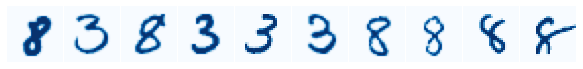

First 10 validation examples:


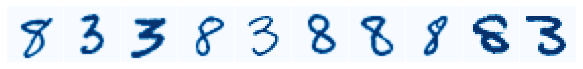

In [4]:
class0,class1 = 3,8 #1,5  #3,8
xnijT,ynT,xnijV,ynV = select (inputs, outputs, [class0,class1], [2500,2500], [2500,2500], shuffle=True) 

print ('First 10 training examples:');   gallery(xnijT[:10], cmap='Blues') ; plt.show()
print ('First 10 validation examples:'); gallery(xnijV[:10], cmap='Blues') ; plt.show()
#======== FLATTEN 28x28 IMAGES INTO 784-ELEMENT VECTORS, AND UNFLATTEN OUTPUTS INTO 1-ELEMENT VECTORS
xndT = xnijT.flatten (1,-1) ; yndT = (ynT.reshape (-1,1) - class0) / (class1-class0)
xndV = xnijV.flatten (1,-1) ; yndV = (ynV.reshape (-1,1) - class0) / (class1-class0)
_,imax,jmax = xnijT.shape
_,dmax = xndT.shape

---
## 3. Binary classification using SLP

In [5]:
#======== TRAIN
model = nn.Sequential(
  nn.Linear(dmax,1), 
  nn.Sigmoid()
)
lossFunc  = nn.BCELoss()
optimizer = torch.optim.Adam (model.parameters(), lr=0.001)
#================ TRAIN
lossHistory = []
errorHistory = []
model.train()     # choose training mode
def fractionalError (Ynd, ynd):
  yn = ynd.detach().numpy().round().flatten().astype(int)
  Yn = Ynd.detach().numpy().round().flatten().astype(int)
  return np.mean(Yn != yn)
for epoch in range(30001):
  YndT = model(xndT)
  loss = lossFunc(YndT,yndT)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  loss = loss.item()
  lossHistory.append ([epoch,loss])
  if epoch % 5 == 0:
    err = fractionalError (YndT, yndT)
    YndV = model (xndV)
    errV = fractionalError (YndV, yndV)
    errorHistory.append ([epoch, err, errV])
    if epoch % 1000 == 0:
      print ('Epoch {}  Training loss = {:.4f}  Training error = {:.2f}%  Validation error = {:.2f}%'.format(epoch,loss,100*err,100*errV))
  if (loss < 0.01): 
    print ('Termination criteria satisfied!')
    break

Epoch 0  Training loss = 0.6603  Training error = 38.52%  Validation error = 31.26%
Epoch 1000  Training loss = 0.0981  Training error = 2.92%  Validation error = 3.14%
Epoch 2000  Training loss = 0.0816  Training error = 2.48%  Validation error = 3.40%
Epoch 3000  Training loss = 0.0729  Training error = 2.10%  Validation error = 3.44%
Epoch 4000  Training loss = 0.0661  Training error = 1.70%  Validation error = 3.56%
Epoch 5000  Training loss = 0.0604  Training error = 1.50%  Validation error = 3.86%
Epoch 6000  Training loss = 0.0552  Training error = 1.46%  Validation error = 3.94%
Epoch 7000  Training loss = 0.0506  Training error = 1.42%  Validation error = 4.18%
Epoch 8000  Training loss = 0.0466  Training error = 1.24%  Validation error = 4.46%
Epoch 9000  Training loss = 0.0432  Training error = 1.16%  Validation error = 4.82%
Epoch 10000  Training loss = 0.0403  Training error = 1.10%  Validation error = 5.12%
Epoch 11000  Training loss = 0.0378  Training error = 1.06%  Vali

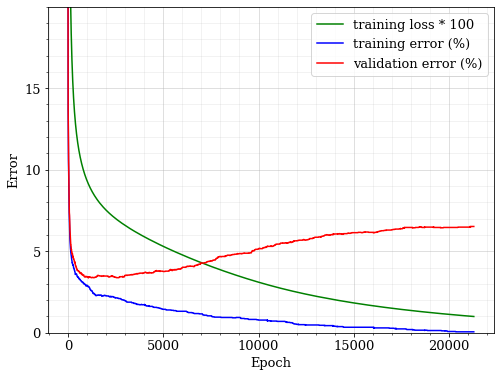

In [6]:
figure = plt.figure(figsize=(8,6))
lossHistory = np.array(lossHistory)
errorHistory = np.array(errorHistory)
plt.plot (lossHistory[:,0],  100*lossHistory[:,1], 'g', label='training loss * 100')
plt.plot (errorHistory[:,0], 100*errorHistory[:,1], 'b', label='training error (%)')
plt.plot (errorHistory[:,0], 100*errorHistory[:,2], 'r', label='validation error (%)')
plt.xlabel ("Epoch"); plt.ylabel ("Error"); plt.ylim ([0,20])
plt.minorticks_on(); plt.yticks(np.arange(0,20,5))
plt.grid (which='major', alpha=0.5)
plt.grid (which='minor', alpha=0.2)
plt.legend();

Weights:


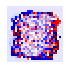

Training Examples:


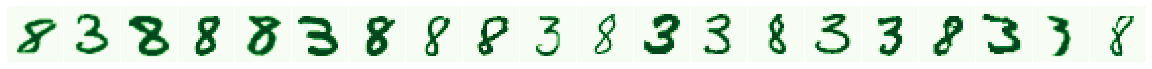

Validation Examples (any misclassified images are shown in red):


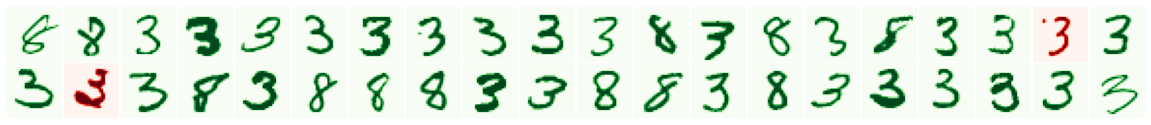

Training error   =    3/5000 =  0.1%    Confusion matrix = [[2497, 3], [0, 2500]]
Validation error =  326/5000 =  6.5%    Confusion matrix = [[2339, 161], [165, 2335]]


In [7]:
#================ EVALUATE ACCURACY FOR BOTH TRAINING AND VALIDATION SETS
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer
#================ DISPLAY WEIGHTS
wij  = model[0].weight.detach().numpy().reshape(imax,jmax)
b    = model[0].bias.detach().item()
plt.show() ; print ('Weights:')
gallery ([wij], cmap='seismic', size=1)
#================ DISPLAY SOME IMAGES AND CLASSIFICATIONS
plt.show() ; print ('Training Examples:')
gallery (xnijT[:20], size=1, cmap=np.where(YnT==ynT,'Greens','Reds'));  #labels=['T{}'.format(n) for n in range(nmax)],
plt.show() ; print ('Validation Examples (any misclassified images are shown in red):')
gallery (xnijV[:40], size=1, cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show();
#================ PRINT METRICS
ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))

---
## 4. Binary classification using simple CNN

In [8]:
#======== TRAIN
cmax = 1                            # number of channels
kmax = 24                           # kernel size
model = nn.Sequential(              # input 28x28 ?
  nn.Unflatten (1, (1,imax,jmax)),  # out   1x28x28
  nn.Conv2d    (1,cmax, kmax),      # convolutional layer with cmax*kmax*kmax learnable parameters
  #nn.ReLU(),
  nn.MaxPool2d (imax-kmax+1),
  nn.Flatten(),    
  nn.Linear(cmax,1),                # cmax+1 learnable parameters
  nn.Sigmoid()
)
lossFunc  = nn.BCELoss()
optimizer = torch.optim.Adam (model.parameters(), lr=0.001)
#================ TRAIN
lossHistory = []
errorHistory = []
model.train()     # choose training mode
def fractionalError (Ynd, ynd):
  yn = ynd.detach().numpy().round().flatten().astype(int)
  Yn = Ynd.detach().numpy().round().flatten().astype(int)
  return np.mean(Yn != yn)
for epoch in range(30001):
  YndT = model(xndT)
  loss = lossFunc(YndT,yndT)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  loss = loss.item()
  lossHistory.append ([epoch,loss])
  if epoch % 5 == 0:
    err = fractionalError (YndT, yndT)
    YndV = model (xndV)
    errV = fractionalError (YndV, yndV)
    errorHistory.append ([epoch, err, errV])
    if epoch % 100 == 0:
      print ('Epoch {:5}  Training loss = {:.4f}  Training error = {:.2f}%  Validation error = {:.2f}%'.format(epoch,loss,100*err,100*errV))
  if (loss < 0.01): 
    print ('Termination criteria satisfied!')
    break

Epoch     0  Training loss = 0.7147  Training error = 50.00%  Validation error = 50.00%
Epoch   100  Training loss = 0.4160  Training error = 10.14%  Validation error = 11.06%
Epoch   200  Training loss = 0.2473  Training error = 5.52%  Validation error = 5.90%
Epoch   300  Training loss = 0.1727  Training error = 4.04%  Validation error = 4.24%
Epoch   400  Training loss = 0.1354  Training error = 3.24%  Validation error = 3.54%
Epoch   500  Training loss = 0.1138  Training error = 2.92%  Validation error = 3.24%
Epoch   600  Training loss = 0.0995  Training error = 2.74%  Validation error = 3.02%
Epoch   700  Training loss = 0.0893  Training error = 2.48%  Validation error = 2.84%
Epoch   800  Training loss = 0.0812  Training error = 2.32%  Validation error = 2.62%
Epoch   900  Training loss = 0.0747  Training error = 2.18%  Validation error = 2.46%
Epoch  1000  Training loss = 0.0696  Training error = 2.00%  Validation error = 2.42%
Epoch  1100  Training loss = 0.0652  Training erro

KeyboardInterrupt: 

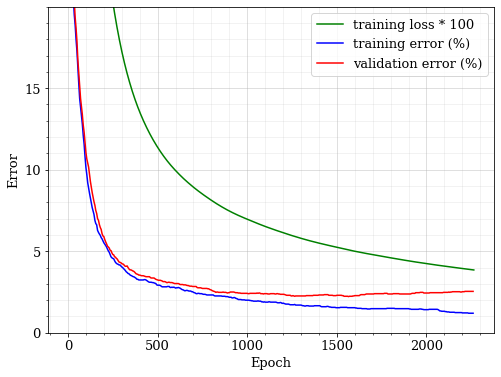

In [9]:
figure = plt.figure(figsize=(8,6))
lossHistory = np.array(lossHistory)
errorHistory = np.array(errorHistory)
plt.plot (lossHistory[:,0],  100*lossHistory[:,1], 'g', label='training loss * 100')
plt.plot (errorHistory[:,0], 100*errorHistory[:,1], 'b', label='training error (%)')
plt.plot (errorHistory[:,0], 100*errorHistory[:,2], 'r', label='validation error (%)')
plt.xlabel ("Epoch"); plt.ylabel ("Error"); plt.ylim ([0,20])
plt.minorticks_on(); plt.yticks(np.arange(0,20,5))
plt.grid (which='major', alpha=0.5)
plt.grid (which='minor', alpha=0.2)
plt.legend();

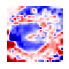

CNN Weights
Training Examples:


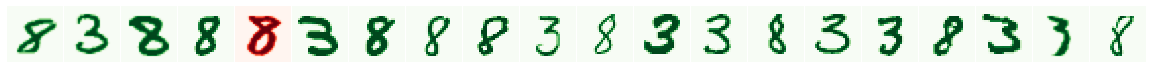

Validation Examples (any misclassified images are shown in red):


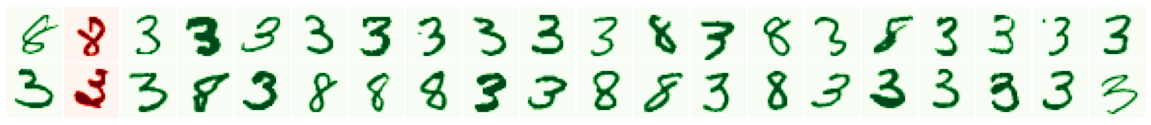

Training error   =   60/5000 =  1.2%    Confusion matrix = [[2461, 39], [21, 2479]]
Validation error =  127/5000 =  2.5%    Confusion matrix = [[2430, 70], [57, 2443]]


In [10]:
#================ EVALUATE ACCURACY FOR BOTH TRAINING AND VALIDATION SETS
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer
#================ DISPLAY WEIGHTS
wccij = model[1].weight.detach().numpy()
cmax,_,I,J = wccij.shape
bc = model[1].bias.detach()
gallery (wccij.reshape (cmax, I, J), cmap='seismic') #labels=['Channel {}'.format(c) for c in range(cmax)], 
plt.show() ; print ('CNN Weights')
#================ DISPLAY SOME IMAGES AND CLASSIFICATIONS
plt.show() ; print ('Training Examples:')
gallery (xnijT[:20], size=1, cmap=np.where(YnT==ynT,'Greens','Reds'));  #labels=['T{}'.format(n) for n in range(nmax)],
plt.show() ; print ('Validation Examples (any misclassified images are shown in red):')
gallery (xnijV[:40], size=1, cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show();
#================ PRINT METRICS
ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))

---
## 5. Binary classification using complex CNN

In [11]:
#======== TRAIN
model = nn.Sequential(               # 28x28 ?
  nn.Unflatten (1, (1,28,28)),       # 1x28x28
  nn.Conv2d    (1, 8, 5, padding=2), # 1x28x28 (after conv with 5x5 kernel and 2x2 padding)
  nn.ReLU(),
  nn.MaxPool2d (2),                  # 1x14x14 after pooling layer with 2x2 kernel
  nn.Conv2d    (8, 16, 5),           # 6x10x10 after conv with 5x5 kernel and no padding
  nn.ReLU(),
  nn.MaxPool2d (2),                  # 16x5x5
  nn.Flatten(),    
  nn.Linear(16*5*5,84),              # 84
  nn.ReLU(),
  nn.Linear(84,1),                   # 1
  nn.Sigmoid()
)
lossFunc  = nn.BCELoss()
optimizer = torch.optim.Adam (model.parameters(), lr=0.001)
#================ TRAIN
lossHistory = []
errorHistory = []
model.train()     # choose training mode
def fractionalError (Ynd, ynd):
  yn = ynd.detach().numpy().round().flatten().astype(int)
  Yn = Ynd.detach().numpy().round().flatten().astype(int)
  return np.mean(Yn != yn)
for epoch in range(30001):
  YndT = model(xndT)
  loss = lossFunc(YndT,yndT)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  loss = loss.item()
  lossHistory.append ([epoch,loss])
  if epoch % 5 == 0:
    err = fractionalError (YndT, yndT)
    YndV = model (xndV)
    errV = fractionalError (YndV, yndV)
    errorHistory.append ([epoch, err, errV])
    if epoch % 20 == 0:
      print ('Epoch {:5}  Training loss = {:.4f}  Training error = {:.2f}%  Validation error = {:.2f}%'.format(epoch,loss,100*err,100*errV))
  if (loss < 0.01): 
    print ('Termination criteria satisfied!')
    break

Epoch     0  Training loss = 0.6956  Training error = 51.14%  Validation error = 32.14%
Epoch    20  Training loss = 0.2787  Training error = 8.78%  Validation error = 8.86%
Epoch    40  Training loss = 0.1026  Training error = 3.24%  Validation error = 3.84%
Epoch    60  Training loss = 0.0595  Training error = 1.76%  Validation error = 1.88%
Epoch    80  Training loss = 0.0365  Training error = 1.06%  Validation error = 1.08%
Epoch   100  Training loss = 0.0240  Training error = 0.60%  Validation error = 0.80%
Epoch   120  Training loss = 0.0172  Training error = 0.46%  Validation error = 0.68%
Epoch   140  Training loss = 0.0127  Training error = 0.34%  Validation error = 0.56%
Termination criteria satisfied!


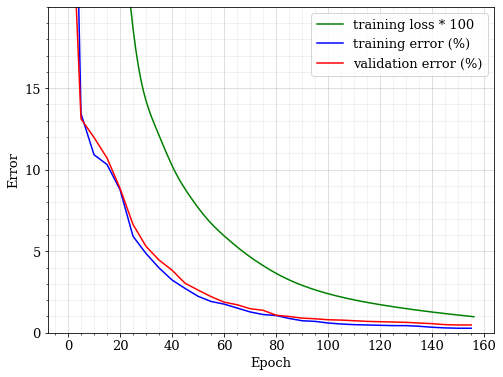

In [16]:
figure = plt.figure(figsize=(8,6))
lossHistory = np.array(lossHistory)
errorHistory = np.array(errorHistory)
plt.plot (lossHistory[:,0],  100*lossHistory[:,1], 'g', label='training loss * 100')
plt.plot (errorHistory[:,0], 100*errorHistory[:,1], 'b', label='training error (%)')
plt.plot (errorHistory[:,0], 100*errorHistory[:,2], 'r', label='validation error (%)')
plt.xlabel ("Epoch"); plt.ylabel ("Error"); plt.ylim ([0,20])
plt.minorticks_on(); plt.yticks(np.arange(0,20,5))
plt.grid (which='major', alpha=0.5)
plt.grid (which='minor', alpha=0.2)
plt.legend();

In [17]:
wccij = model[4].weight.detach().flatten(0,1)
wccij.shape

torch.Size([128, 5, 5])

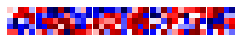

First Convolutional Layer Weights


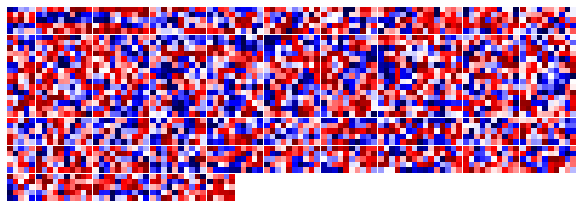

Second Convolutional Layer Weights
Training Examples:


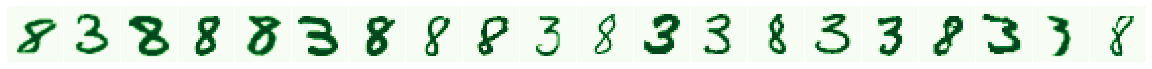

Validation Examples (any misclassified images are shown in red):


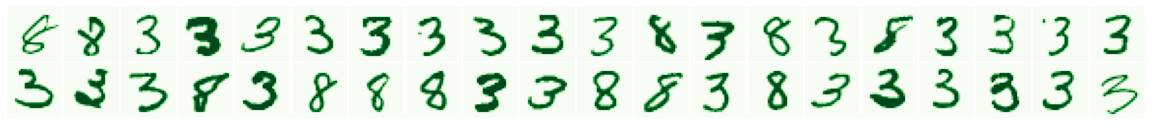

Training error   =   13/5000 =  0.3%    Confusion matrix = [[2493, 7], [6, 2494]]
Validation error =   25/5000 =  0.5%    Confusion matrix = [[2482, 18], [7, 2493]]


In [18]:
#================ EVALUATE ACCURACY FOR BOTH TRAINING AND VALIDATION SETS
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer
#================ DISPLAY WEIGHTS
wccij = model[1].weight.detach() ; wcij = wccij.flatten(0,1).numpy()
cmax,I,J = wcij.shape
gallery (wcij, cmap='seismic', size=.5)
plt.show() ; print ('First Convolutional Layer Weights')
wccij = model[4].weight.detach() ; wcij = wccij.flatten(0,1).numpy()
cmax,I,J = wcij.shape
gallery (wcij, cmap='seismic', size=.5) #labels=['Channel {}'.format(c) for c in range(cmax)], 
plt.show() ; print ('Second Convolutional Layer Weights')
#================ DISPLAY SOME IMAGES AND CLASSIFICATIONS
plt.show() ; print ('Training Examples:')
gallery (xnijT[:20], size=1, cmap=np.where(YnT==ynT,'Greens','Reds'));  #labels=['T{}'.format(n) for n in range(nmax)],
plt.show() ; print ('Validation Examples (any misclassified images are shown in red):')
gallery (xnijV[:40], size=1, cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show();
#================ PRINT METRICS
ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))

Misclassified examples in validation set


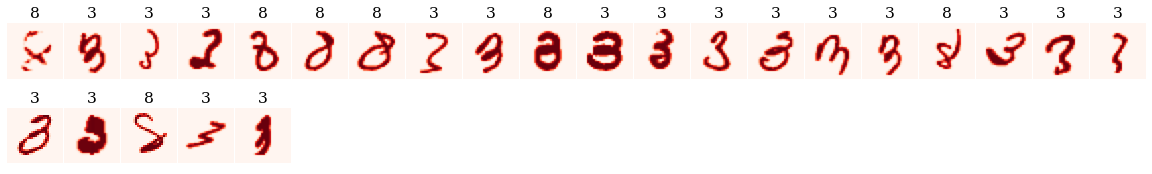

(array([ 115,  647,  648,  649,  955, 1633, 1644, 1748, 1949, 2054, 2065, 2125, 2355, 2460, 2580, 2606, 2962, 3201, 3339, 3535, 4025, 4659, 4772, 4834, 4866]),)

In [22]:
print ('Misclassified examples in validation set')
nMistakes, = np.where(YnV!=ynV)
gallery (xnijV[nMistakes], labels=class0+(class1-class0)*ynV[nMistakes], size=1, cmap='Reds'); plt.show();
np.where(YnV!=ynV)

---
## Conclusions

We picked the following from the MNIST-TRAIN set:

    Training set:   2500 3's, 2500 8's
    Validation set: 2500 3's, 2500 8's

Performance was as follows.

    Error                                Training  Validation
    SLP                                    0.1%     5.6%
    Single-layer CNN with 24x24 kernel     0.1%     5.0%    (or something similar)
    LeNet-like CNN with 2 Conv2d layers    0.0%     0.5%
    